In [27]:
import cv2
import numpy as np
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

In [56]:
def face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.imwrite("im.png", img)
    return faces

In [29]:
def skinmask(img):
    temp= cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    lab_image = cv2.cvtColor(temp, cv2.COLOR_BGR2LAB)
    hsv_image = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv_image)
    l,a,b = cv2.split(lab_image)
    skinMask = ((a-143)/(6.5))*((a-143)/(6.5)) + ((b-148)/(12))*((b-148)/(12))<1
    Ms = skinMask.astype('uint8') & ((s<0.25).astype('uint8') | (s>0.75).astype('uint8')).astype('uint8') & (h<0.095).astype('uint8')

In [30]:
def wlsfilter(image_orig, lambda_=0.4, alpha=1.2, small_eps=1e-4):
    """
    ARGs:
    -----
    image: 0-255, uint8, single channel (e.g. grayscale or single L)
    lambda_:
    alpha:
    RETURN:
    -----
    out: base, 0-1, float
    detail: detail, 0-1, float
    """
    print('wls: lambda, alpha', lambda_, alpha)
    image = image_orig.astype(np.float)/255.0
    s = image.shape
    k = np.prod(s)

    dy = np.diff(image, 1, 0)
    dy = -lambda_ / (np.absolute(dy) ** alpha + small_eps)
    dy = np.vstack((dy, np.zeros(s[1], )))
    dy = dy.flatten()

    dx = np.diff(image, 1, 1)
    dx = -lambda_ / (np.absolute(dx) ** alpha + small_eps)
    dx = np.hstack((dx, np.zeros(s[0], )[:, np.newaxis]))
    dx = dx.flatten()
    
    a = spdiags(np.vstack((dx, dy)), [-s[0], -1], k, k)

    d = 1 - (dx + np.roll(dx, s[0]) + dy + np.roll(dy, 1))
    a = a + a.T + spdiags(d, 0, k, k)
    _out = spsolve(a, image.flatten()).reshape(s[::-1])
    out = np.rollaxis(_out,1)

    detail = image - out
    return out, detail

In [110]:
from scipy.signal import argrelextrema
from matplotlib import pyplot as plt
def isBiModal(img):
    im1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(im1,(5,5),0)
    hist = cv2.calcHist([blur],[0],None,[256],[0,256])
    plt.hist(img.ravel(),256,[0,256])
    plt.show()
    maxI = [ argrelextrema(hist, np.greater, order=1)[0]]
    # argrelextrema return (array([ 54, 132]),) (a tuple), only [0] used for 1d
    minI = [ argrelextrema(hist, np.less, order=1)[0]]
    print(len(maxI))
    print(len(maxI))
    if(len(maxI)>=2 and len(minI)>=1):
        return True, maxI[0], maxI[1], minI[0]
    else:
        return None


(243, 363, 3)
wls: lambda, alpha 0.4 1.2


/var/folders/9r/c944g64j4s77mdbqybgdg0f00000gn/T/ipykernel_33897/2296735934.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image_orig.astype(np.float)/255.0
/Users/deepanshu/miniconda3/envs/col783/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


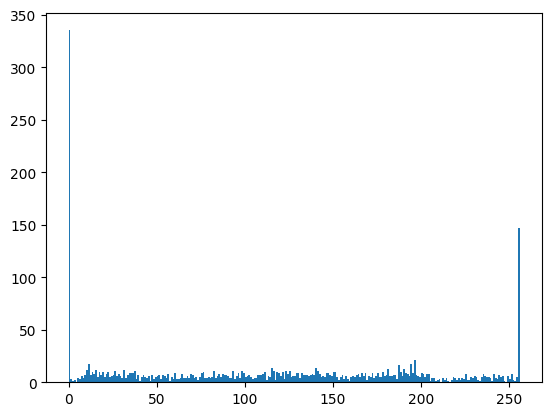

1
1


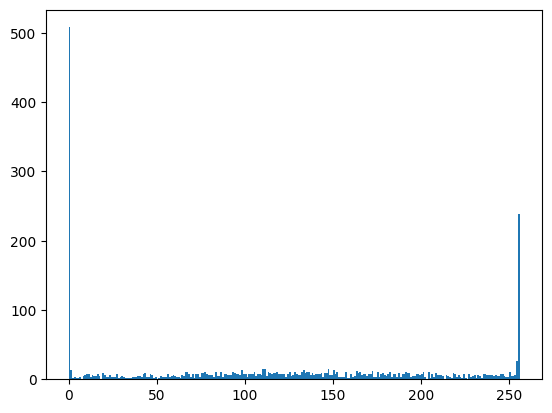

1
1


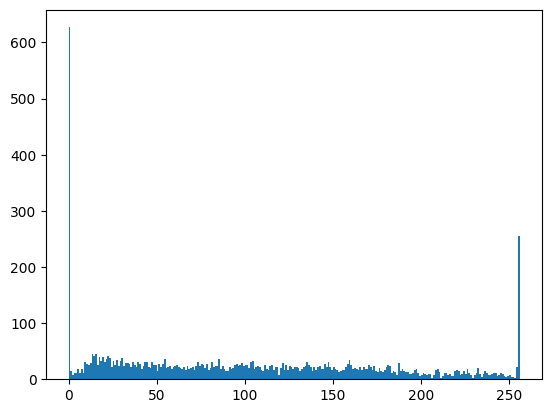

1
1


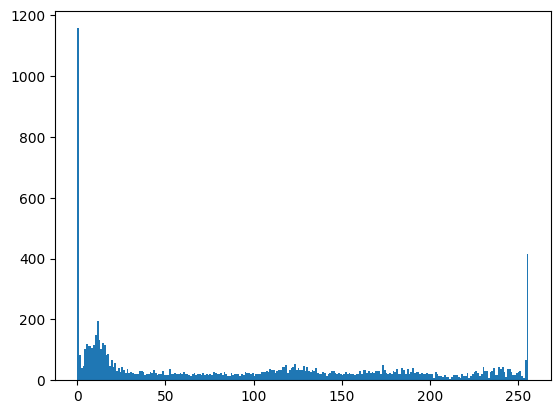

1
1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


True

In [111]:
img = cv2.imread("f.png")
print(img.shape)
faces = face(img)
skinMask = skinmask(img)
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l,a,b = cv2.split(lab_image)
base, detail = wlsfilter(l)
ans = base
A = np.zeros((img.shape[0], img.shape[1]))
for (x,y,w,h) in faces:
    temp = np.zeros((w,h))
    temp = img[y:y+h, x:x+w, :]
    ar = isBiModal(temp)
    if(ar==None):
        continue
    else:
        print("HERE")
        d = ar[1]
        b = ar[2]
        m = ar[3]
        factor = (b-d)/(m-d)
        for i in range(x,x+w):
            for j in range(y,y+h):
                if(skinMask[i][j] and img[i][j]<=m):
                    A[i][j] = A[i][j] + factor*img[i][j]
        
ans = ans*A
print(A)
ans = ans + detail
cv2.imwrite('res.png',ans)